### Imports Needed

In [13]:
import numpy as np
import h5py
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import GradcamPlusPlus, Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
import json
import pickle
from scipy.ndimage import zoom

## Load Model

In [14]:
def load_data(path):
    with h5py.File(path, 'r') as f:
        x = f['image'][()]
        y = f['label'][()]
    return np.array(x), np.array(y)


# Set this to none if you will manually input the needed variables
dataJson = r"C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\data.json"

# Image dimensions that the model was trained on
# Manually Set This If data.json does not exist, otherwise can leave as None
# input_dimensions = [96, 96, 1]
input_dimensions = None

# Class Names
# Manually Set This If data.json does not exist, otherwise can leave as None
# class_names = ["Cat", "Dog"]
class_names = None

# Number of classes
# Manually Set This If data.json does not exist, otherwise can leave as None
# num_classes = 2
num_classes = None

# Automatically read the input_dimensions, class_names and num_classes from a data.json if it exists
if dataJson is not None:
    with open(dataJson, "r") as f:
        data = json.load(f)

    input_dimensions = data['input_size']
    class_names = data['class_names']
    num_classes = data['num_classes']
    f.close()

x_test, y_test = load_data(r'C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\test.h5')

# Normalize data
x_test = x_test.reshape(-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]) / 255.0
#y_test = to_categorical(y_test, num_classes=num_classes)

# Load the best saved model
model = load_model('best_model2.h5')

print(model.summary())

Model: "cat_dog_model_standard"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 

### Create Feature Map Objects

In [15]:
# Create GradCAM++ object
gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)
# Create GradCam object
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
# Create SmoothGrad Object
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

Store In A .npy File So We Can Read It After

In [17]:
# Will Only Use Predictions With A Confidence Above 80%
accuracyThreshold = 0.8

# Will Use Only Correct Examples
onlyCorrect = True

# Starting Index
startIndex = 0

# How Many Images To Sample Given The Requirements
# If This Is None, It will Use All Possible, Otherwise it will take x consecutive images
# amountOfSamples = 5
amountOfSamples = 25

results = []
correct_samples_collected = 0
# Not sure why CategoricalScore([0,1])  doesnt work as CategoricalScore(0) and CategoricalScore(1) both work and give different outputs
# https://keisen.github.io/tf-keras-vis-docs/api/tf_keras_vis.utils.scores.html

# Loop over the specified range of indices
i = startIndex
while (amountOfSamples is None or correct_samples_collected < amountOfSamples) and i < len(x_test):
    # Calculate saliency map
    saliency_map = saliency(score=CategoricalScore(y_test[i]),
                            seed_input=x_test[i],
                            smooth_samples=50,
                            smooth_noise=0.20)[0]

    # Calculate GradCAM++
    plus_map = gradcam_plus_plus(CategoricalScore(y_test[i]),
                                 x_test[i],
                                 penultimate_layer=-1,
                                 expand_cam=False)[0]

    # Calculate GradCAM
    gradcam_map = gradcam(CategoricalScore(y_test[i]),
                          x_test[i],
                          penultimate_layer=-1,
                          expand_cam=False)[0]

    confidenceScore = model.predict(
        x_test[i].reshape(-1, input_dimensions[0], input_dimensions[1], input_dimensions[2])).flatten().tolist()

    correct = np.argmax(confidenceScore) == y_test[i]

    confidence = confidenceScore[np.argmax(confidenceScore)]

    if (confidence >= accuracyThreshold) and (not onlyCorrect or correct):
        results.append((i, saliency_map, plus_map, gradcam_map, y_test[i], confidence))
        print(f"Saving {i} To Output")
        correct_samples_collected += 1

    i += 1

# Save the results using pickle
with open('gradcam-outputs.pkl', 'wb') as f:
    pickle.dump(results, f)

    # Resize the feature maps to match the input image dimensions

    # Normalize saliency map for visualization
    # saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    # 
    # scale_factor = (input_dimensions[0] / saliency_map.shape[0], input_dimensions[1] / saliency_map.shape[1])
    # saliency_map_resized = zoom(saliency_map, scale_factor)
    # 
    # scale_factor = (input_dimensions[0] / plus_map.shape[0], input_dimensions[1] / plus_map.shape[1])
    # plus_map_resized = zoom(plus_map, scale_factor)
    # 
    # scale_factor = (input_dimensions[0] / gradcam_map.shape[0], input_dimensions[1] / gradcam_map.shape[1])
    # gradcam_map_resized = zoom(gradcam_map, scale_factor)



1/1 [==============================] - 0s 20ms/step
Saving 0 To Output
1/1 [==============================] - 0s 20ms/step
Saving 2 To Output
1/1 [==============================] - 0s 20ms/step
Saving 3 To Output
1/1 [==============================] - 0s 22ms/step
Saving 4 To Output
1/1 [==============================] - 0s 21ms/step
Saving 5 To Output
1/1 [==============================] - 0s 21ms/step
Saving 6 To Output
1/1 [==============================] - 0s 22ms/step
Saving 8 To Output
1/1 [==============================] - 0s 21ms/step
Saving 9 To Output
1/1 [==============================] - 0s 20ms/step
Saving 10 To Output
1/1 [==============================] - 0s 21ms/step
Saving 14 To Output
1/1 [==============================] - 0s 20ms/step
Saving 16 To Output
1/1 [==============================] - 0s 21ms/step
Saving 17 To Output
1/1 [==============================] - 0s 20ms/step
Saving 19 To Output
1/1 [==============================] - 0s 20ms/step
Saving 20 To Output


## View The data distribution

In [24]:
# Initialize lists to store the statistics
max_values_correct = []
min_values_correct = []
avg_values_correct = []

# max_values_incorrect = []
# min_values_incorrect = []
# avg_values_incorrect = []

# Iterate through all the predictions in loaded_array
for prediction in results:
    index, saliency_map, plus_map, gradcam_map, correct_class, confidence = prediction

    # Convert correct_class to int (if necessary)
    correct_class = int(correct_class)

    # Assuming we are working with the gradcam_map as the feature map
    feature_map = gradcam_map

    # Flatten the correct class feature map
    flattened_correct = feature_map

    # Normalize from 0-1 (optional)
    # flattened_correct = flattened_correct / np.max(flattened_correct)

    # Flatten all incorrect class feature maps (excluding the correct class)
    # Removes the correct prediction and flattens all the incorrect classes into a single array
    #flattened_incorrect = np.delete(feature_map, correct_class, axis=2).flatten()

    # Normalize from 0-1 (optional)
    # flattened_incorrect = flattened_incorrect / np.max(flattened_incorrect)

    # Calculate and store the statistics for correct class
    max_values_correct.append(np.max(flattened_correct))
    min_values_correct.append(np.min(flattened_correct))
    avg_values_correct.append(np.mean(flattened_correct))

    # Calculate and store the statistics for incorrect classes
    # max_values_incorrect.append(np.max(flattened_incorrect))
    # min_values_incorrect.append(np.min(flattened_incorrect))
    # avg_values_incorrect.append(np.mean(flattened_incorrect))

# Convert lists to NumPy arrays for efficient numerical operations
max_values_correct = np.array(max_values_correct)
min_values_correct = np.array(min_values_correct)
avg_values_correct = np.array(avg_values_correct)

# max_values_incorrect = np.array(max_values_incorrect)
# min_values_incorrect = np.array(min_values_incorrect)
# avg_values_incorrect = np.array(avg_values_incorrect)


## Plotting The Data

Mean values:
Correct Capsule = 0.35846179723739624



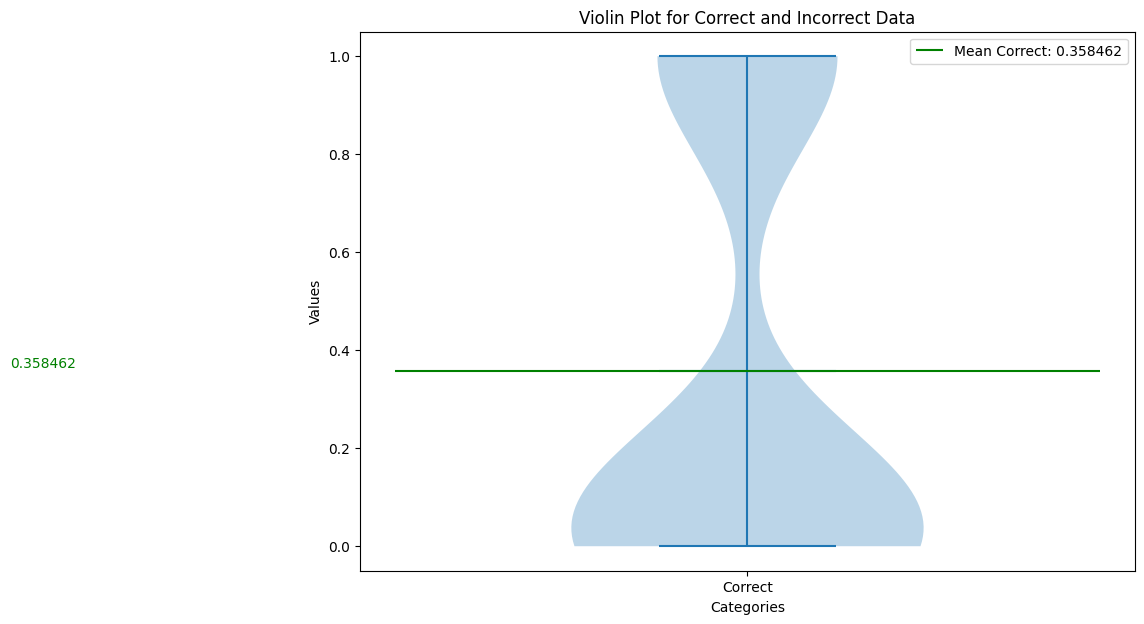

In [27]:
correctVals = np.concatenate((min_values_correct, max_values_correct, avg_values_correct))
#incorrectVals = np.concatenate((min_values_incorrect, max_values_incorrect, avg_values_incorrect))

# Data for plotting
#data = [correctVals, incorrectVals]
#labels = ['Correct', 'Incorrect']

data = [correctVals]
labels = ["Correct"]

# Combine the data into one list
# data = [correctVals, incorrectVals]

# Calculate means
means = [np.mean(correctVals)]  #, np.mean(incorrectVals)
print(f"Mean values:\n"
      f"Correct Capsule = {means[0]}\n")  # f"Incorrect Capsule = {means[1]}\n"

fig, ax = plt.subplots(figsize=(10, 7))

# Create the violin plot
plt.violinplot(data, showmeans=True, showmedians=False)

# Add x-axis labels
plt.xticks([1], ['Correct'])  #, 'Incorrect'

# Title and labels
plt.title('Violin Plot for Correct and Incorrect Data')
plt.ylabel('Values')
plt.xlabel('Categories')

# Add horizontal lines for means
ax.hlines(y=means[0], xmin=0.5, xmax=1.5, colors='green', linestyles='solid', label=f'Mean Correct: {means[0]:.6f}')
#ax.hlines(y=means[1], xmin=1.5, xmax=2.5, colors='red', linestyles='solid', label=f'Mean Incorrect: {means[1]:.6f}')

# Annotate means on the plot
plt.text(0, means[0], f'{means[0]:.6f}', ha='center', va='bottom', color='green')
#plt.text(0, means[1], f'{means[1]:.6f}', ha='center', va='bottom', color='red')

# Add legend
plt.legend()

# Show plot
plt.show()

## Apply the image mask

1/1 [==============================] - 0s 24ms/step


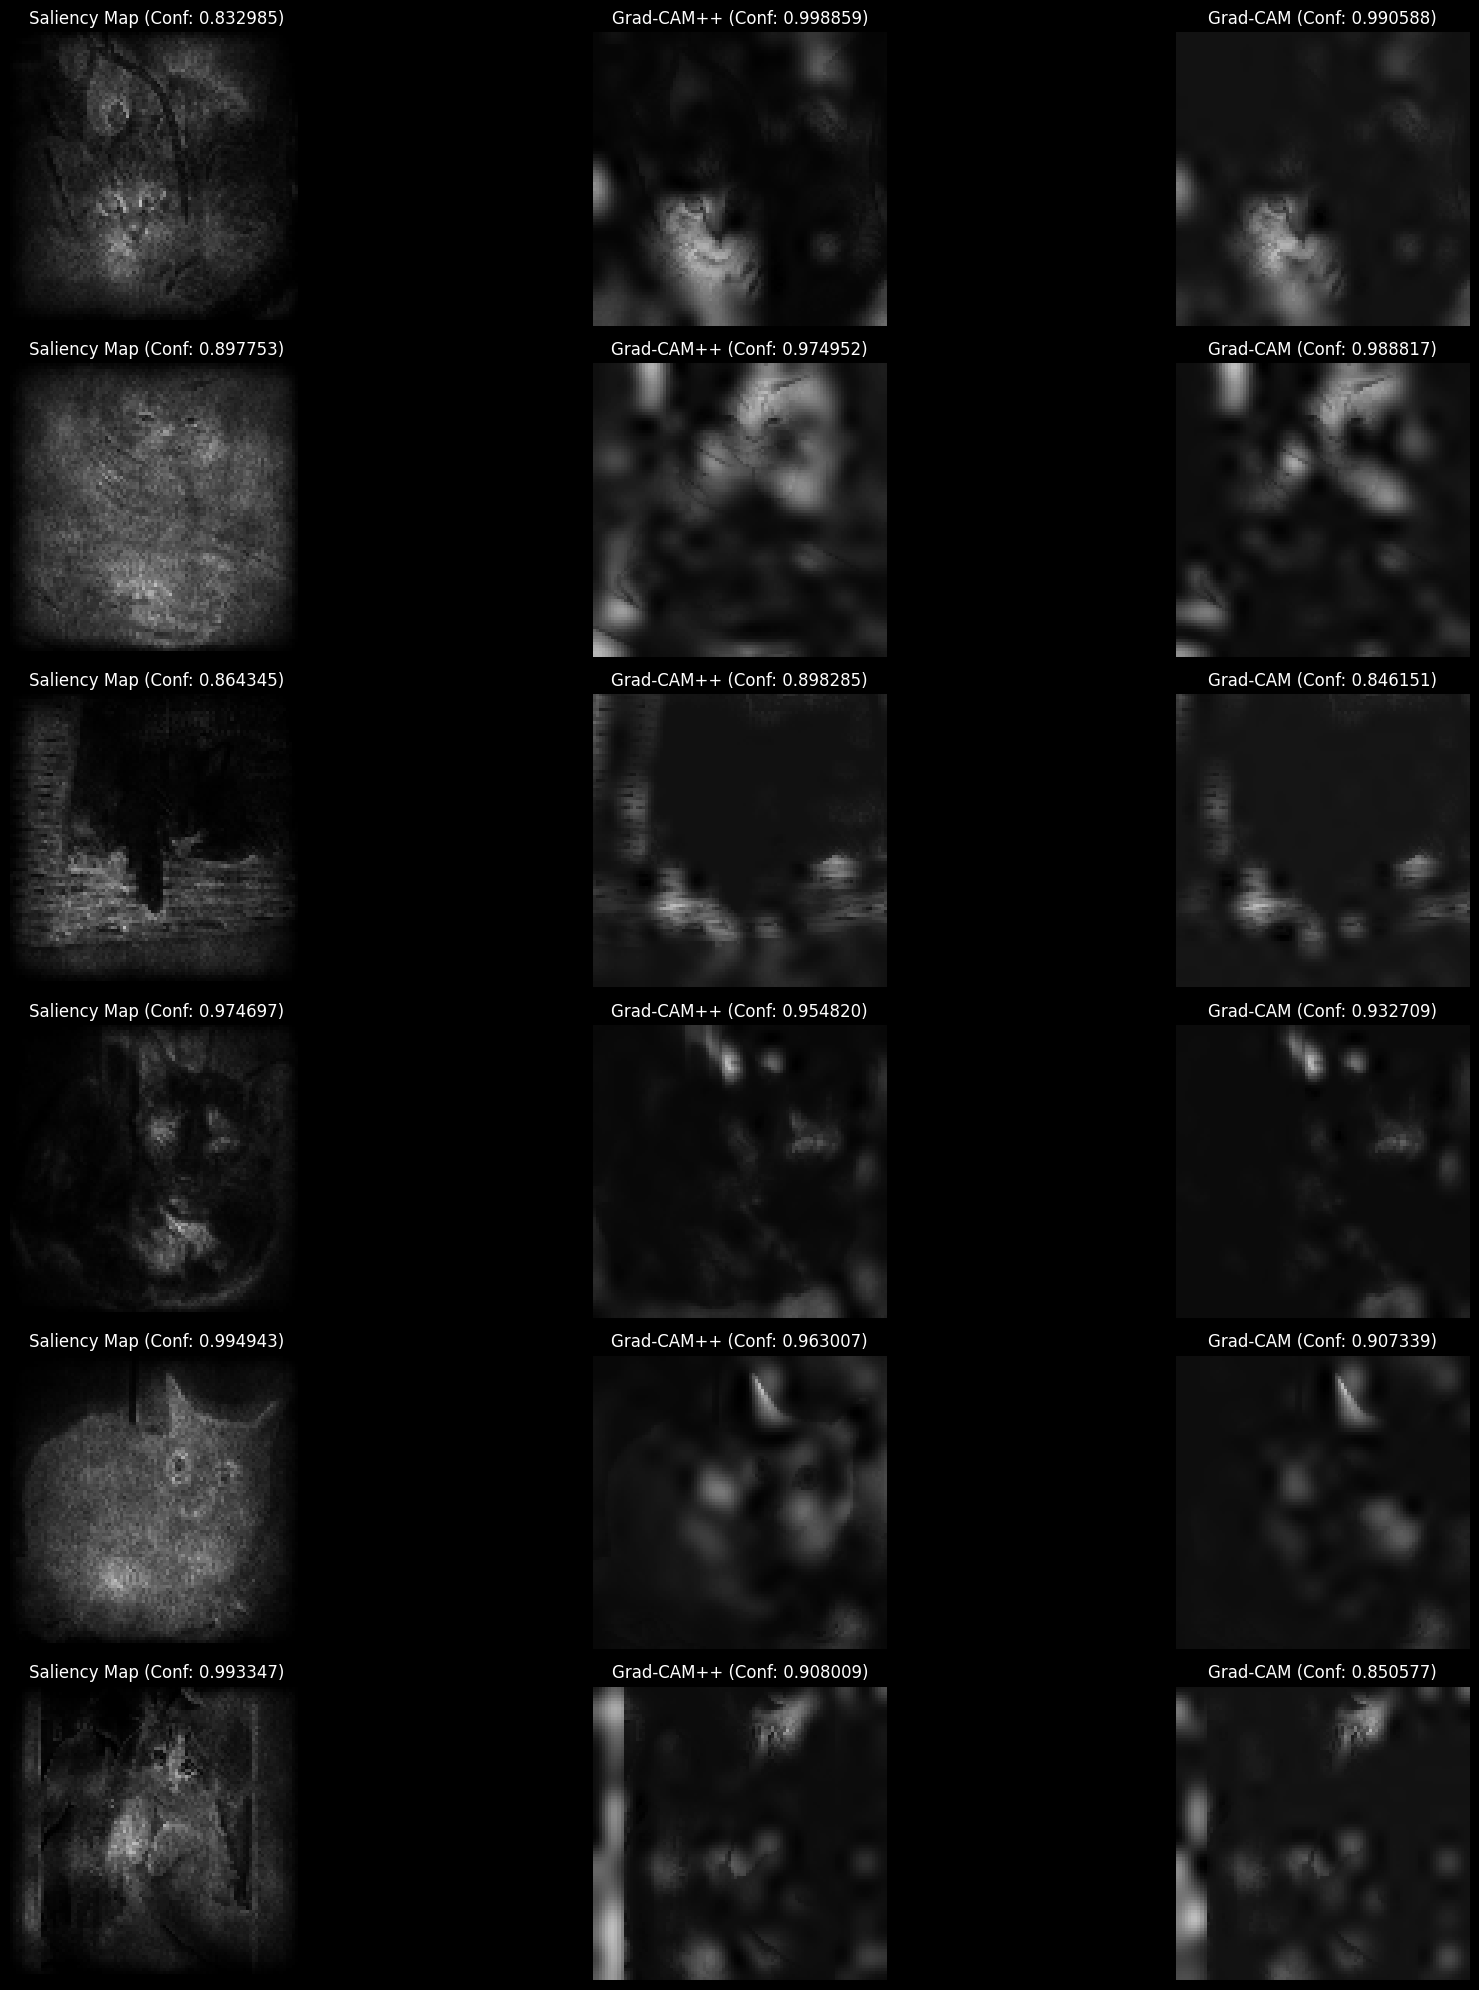

Average Confidence Change Of:
Saliency Map: -0.024936825037002563
Gradcam++ Map: -0.001626590887705485
Gradcam Map: -0.031918237606684365



In [43]:
# Configuration parameters
startingIndex = 0
endIndex = 6
backColour = 'black'
textColour = 'white'
alphaValue = 0.75
defaultColourMap = 'gray'
decimalPrecision = 6

totalChange = [0.0, 0.0, 0.0]

# Number of images to plot
num_images = endIndex - startingIndex

# Determine the grid size for subplots (3 columns for 3 feature maps per image)
num_cols = 3
num_rows = num_images

# Create a figure with the desired number of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), facecolor=backColour)


# Function to renormalize an array to the range [0, 1]
def renormalize(array):
    array_min = np.min(array)
    array_max = np.max(array)
    return (array - array_min) / (array_max - array_min)


for i in range(startingIndex, endIndex):
    index, saliency_map, plus_map, gradcam_map, correct_class, confidence1 = results[i]

    saliency_map = np.array(saliency_map)
    plus_map = np.array(plus_map)
    gradcam_map = np.array(gradcam_map)

    scale_factor_saliency_map = (
        input_dimensions[0] / saliency_map.shape[0], input_dimensions[1] / saliency_map.shape[1])
    scale_factor_plus_map = (input_dimensions[0] / plus_map.shape[0], input_dimensions[1] / plus_map.shape[1])
    scale_factor_gradcam_map = (input_dimensions[0] / gradcam_map.shape[0], input_dimensions[1] / gradcam_map.shape[1])

    # Apply zoom and multiplication, then renormalize
    resized_featureMap_saliency_map = renormalize(
        zoom(saliency_map, scale_factor_saliency_map).reshape(input_dimensions[0], input_dimensions[1],
                                                              input_dimensions[2]) * x_test[index])
    resized_featureMap_plus_map = renormalize(
        zoom(plus_map, scale_factor_plus_map).reshape(input_dimensions[0], input_dimensions[1],
                                                      input_dimensions[2]) * x_test[index])
    resized_featureMap_gradcam_map = renormalize(
        zoom(gradcam_map, scale_factor_gradcam_map).reshape(input_dimensions[0], input_dimensions[1],
                                                            input_dimensions[2]) * x_test[index])

    # Re-predict for saliency map
    confidenceScore = model.predict(
        resized_featureMap_saliency_map.reshape(-1, input_dimensions[0], input_dimensions[1],
                                                input_dimensions[2])).flatten().tolist()
    confidence2Saliency = confidenceScore[np.argmax(confidenceScore)]

    # Re-predict for gradcam++
    confidenceScore = model.predict(resized_featureMap_plus_map.reshape(-1, input_dimensions[0], input_dimensions[1],
                                                                        input_dimensions[2])).flatten().tolist()
    confidence2Plus = confidenceScore[np.argmax(confidenceScore)]

    # Re-predict for gradcam
    confidenceScore = model.predict(resized_featureMap_gradcam_map.reshape(-1, input_dimensions[0], input_dimensions[1],
                                                                           input_dimensions[2])).flatten().tolist()
    confidence2Grad = confidenceScore[np.argmax(confidenceScore)]

    totalChange[0] += confidence2Saliency - confidence1
    totalChange[1] += confidence2Plus - confidence1
    totalChange[2] += confidence2Grad - confidence1
    
    # Plot the feature maps
    axes[i - startingIndex, 0].imshow(resized_featureMap_saliency_map, cmap=defaultColourMap, alpha=alphaValue)
    axes[i - startingIndex, 0].set_title(f"Saliency Map (Conf: {confidence2Saliency:.{decimalPrecision}f})",
                                         color=textColour)
    axes[i - startingIndex, 0].axis('off')

    axes[i - startingIndex, 1].imshow(resized_featureMap_plus_map, cmap=defaultColourMap, alpha=alphaValue)
    axes[i - startingIndex, 1].set_title(f"Grad-CAM++ (Conf: {confidence2Plus:.{decimalPrecision}f})", color=textColour)
    axes[i - startingIndex, 1].axis('off')

    axes[i - startingIndex, 2].imshow(resized_featureMap_gradcam_map, cmap=defaultColourMap, alpha=alphaValue)
    axes[i - startingIndex, 2].set_title(f"Grad-CAM (Conf: {confidence2Grad:.{decimalPrecision}f})", color=textColour)
    axes[i - startingIndex, 2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Print average confidence change
print(f"Average Confidence Change Of:\n"
      f"Saliency Map: {totalChange[0] / (endIndex-startingIndex)}\n"
      f"Gradcam++ Map: {totalChange[1] / (endIndex-startingIndex)}\n"
      f"Gradcam Map: {totalChange[2] / (endIndex-startingIndex)}\n")
